# **Quantization in PyTorch**

<div style="border: 3px solid #222; padding: 16px; border-radius: 10px; background-color: #1c1f26; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; color: #e0e0e0;">
  <div style="display: flex; align-items: center; gap: 8px; margin-top: 12px;">
    <span style="font-size: 24px; color: #ff5555;">&#128274;</span>
    <span style="font-size: 16px;"><strong>Project:</strong> Transfer Learning</span>
  </div>
  <div style="display: flex; align-items: center; gap: 8px; margin-top: 8px;">
    <span style="font-size: 20px; color: #ff5555;">&#128218;</span>
    <span style="font-size: 16px;"><strong>Course:</strong> Deep Network Development</span>
  </div>
  <div style="margin-top: 12px; font-size: 14px;">
    <span style="font-size: 18px; color: #6e8192;">&#128100;</span>
    <span style="font-weight: bold;"><strong>Authors:</strong></span> Tamás Takács, Imre Molnár (PhD students, Department of Artificial Intelligence, Eötvös Loránd University)
  </div>
</div>
<hr style="border: none; border-top: 2px solid #444;">
<br>

<img src="https://miro.medium.com/v2/resize:fit:2000/1*hW4ji0HV5fb_FBaSPyHSCA.png" alt="quantization" border="0">

The problem we're going to solve today is to train a model to classify
**ants** and **bees** utilizing a pre-trained **ResNet-18** model and **quantization techniques**. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

Quantization is an important technique for optimizing neural networks, particularly for deployment on resource-constrained devices such as mobile phones and edge devices. PyTorch offers several methods for quantizing models, each suited to different use cases.

The three main types of quantization in PyTorch are:

1. **Dynamic Quantization**: In dynamic quantization, only the model weights are quantized (typically from 32-bit floating point to 8-bit integers) at runtime. This form of quantization is relatively simple to implement and is effective in models with large fully connected layers, such as NLP models like LSTMs and Transformers.
   
2. **Static Quantization (Post-Training Quantization)**: Both weights and activations are quantized statically. This method requires calibration on a sample dataset after training. It is beneficial for models with both convolutional and fully connected layers. Static quantization improves performance by reducing the precision of activations and weights but typically requires calibration data to adjust the scale.
   
3. **Quantization Aware Training (QAT)**: In QAT, quantization is simulated during training. The model learns to adjust its weights and activations to account for the reduced precision. This approach generally provides the best post-quantization accuracy and is especially effective in models where maintaining accuracy is critical, such as for vision tasks or when quantizing convolutional layers.


In [ ]:
# @title Roadmap Generator
%%capture flowchart_output
from graphviz import Digraph

def create_quantization_flowchart(output_filename='quantization_flowchart'):
    dot = Digraph(name='QuantizationTechniques', format='png')
    dot.attr(rankdir='LR')
    dot.attr('node', shape='box', style='filled', fontsize='12', fontname='Arial')

    # Installation & Setup
    dot.node('Install', 'Install Required Packages & Setup\n(Easy)', fillcolor='#A0E7A0')

    # Data Loading and Cleaning
    dot.node('Data', 'Download & Clean Dataset (Ants & Bees)\n(Easy)', fillcolor='#A0E7A0')

    # Model Setup and Fine-tuning
    dot.node('Model', 'Load Pretrained ResNet-18 and Fine-tune\n(Moderate)', fillcolor='#F6D49A')

    # Dynamic Quantization
    dot.node('Dynamic', 'Apply Dynamic Quantization\n(Easy)', fillcolor='#A0E7A0')

    # Benchmarking & Model Size Evaluation
    dot.node('Benchmark', 'Benchmark Inference & Evaluate Model Size\n(Moderate)', fillcolor='#F6D49A')

    # Quantization Aware Training (QAT)
    dot.node('QAT', 'Quantization Aware Training (QAT)\n(Difficult)', fillcolor='#F6A0A0')

    # Model Conversion (from QAT to quantized model)
    dot.node('Convert', 'Convert QAT Model to Fully Quantized Model\n(Moderate)', fillcolor='#F6D49A')

    # Comparison and Conclusion
    dot.node('Compare', 'Compare Quantization Methods & Conclude\n(Easy)', fillcolor='#A0E7A0')

    # Define pipeline flow:
    dot.edge('Install', 'Data')
    dot.edge('Data', 'Model')
    dot.edge('Model', 'Dynamic')
    dot.edge('Dynamic', 'Benchmark')
    dot.edge('Model', 'QAT')
    dot.edge('QAT', 'Convert')
    dot.edge('Benchmark', 'Compare')
    dot.edge('Convert', 'Compare')

    dot.render(output_filename, view=False)

create_quantization_flowchart('quantization_flowchart')


## **Necessary Imports**

In [ ]:
import time
import os
import copy
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from IPython.display import Image as IMG
from torch.optim import lr_scheduler
from torch.quantization import FakeQuantize, get_default_qat_qconfig, prepare_qat, convert
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets, models, transforms
from torch.ao.quantization import QuantStub, DeQuantStub, prepare_qat, convert

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

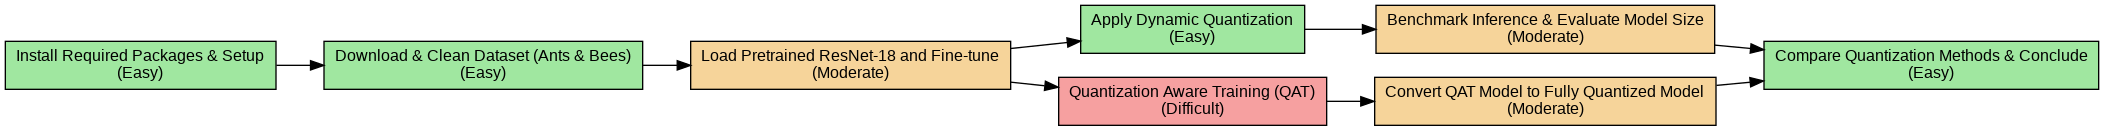

In [ ]:
IMG('quantization_flowchart.png')

## **Loading the Data**

We will use `torchvision` and `torch.utils.data` packages for loading the
data. We are gonna use the `wget` bash command to download the data from the official PyTorch website, then uzing `unzip` to unzip it into a `data` folder. We subsequently remove the downloaded zip file for cleanliness.

Since the original data contains corrupted files, we do a short data cleaning utilzing the find command, to delete all non jpg files.

In [ ]:
%%bash
if [ -d "data" ]; then
    echo "Data folder already exists. Skipping download and extraction."
else
    echo "Data folder does not exist. Downloading and extracting..."
    wget https://download.pytorch.org/tutorial/hymenoptera_data.zip --no-check-certificate --quiet
    unzip -q hymenoptera_data.zip -d data
    rm hymenoptera_data.zip
fi

Data folder does not exist. Downloading and extracting...


In [ ]:
!find data -type f ! -iname "*.jpg" -delete

!echo "Number of training images (ants):" $(find data/hymenoptera_data/train/ants -type f | wc -l)
!echo "Number of training images (bees):" $(find data/hymenoptera_data/train/bees -type f | wc -l)
!echo ""
!echo "Number of validation images (ants):" $(find data/hymenoptera_data/val/ants -type f | wc -l)
!echo "Number of validation images (bees):" $(find data/hymenoptera_data/val/bees -type f | wc -l)

Number of training images (ants): 122
Number of training images (bees): 121

Number of validation images (ants): 70
Number of validation images (bees): 83


We will establish a **dedicated test set** by relocating 40% of the images from the `validation set` into a newly created `test` directory.

In [ ]:
val_dir = 'data/hymenoptera_data/val'
test_dir = 'data/hymenoptera_data/test'

for cls in ['ants', 'bees']:
    # for creating the subdirectories inside the test directory
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

for cls in ['ants', 'bees']:
    cls_val_dir = os.path.join(val_dir, cls)
    cls_test_dir = os.path.join(test_dir, cls)

    files = [f for f in os.listdir(cls_val_dir) if os.path.isfile(os.path.join(cls_val_dir, f))]
    total = len(files)

    # calculating the number of images to move from val to test
    test_count = int(total * 0.4)
    print(f"Moving {test_count} out of {total} '{cls}' images from val to test.")

    random.shuffle(files)
    selected_files = files[:test_count]

    # moving utilizing shutil
    for file in selected_files:
        src_path = os.path.join(cls_val_dir, file)
        dst_path = os.path.join(cls_test_dir, file)
        shutil.move(src_path, dst_path)

Moving 28 out of 70 'ants' images from val to test.
Moving 33 out of 83 'bees' images from val to test.


In [ ]:
!echo "Number of training images (ants):" $(find data/hymenoptera_data/train/ants -type f | wc -l)
!echo "Number of training images (bees):" $(find data/hymenoptera_data/train/bees -type f | wc -l)
!echo ""
!echo "Number of validation images (ants):" $(find data/hymenoptera_data/val/ants -type f | wc -l)
!echo "Number of validation images (bees):" $(find data/hymenoptera_data/val/bees -type f | wc -l)
!echo ""
!echo "Number of test images (ants):" $(find data/hymenoptera_data/test/ants -type f | wc -l)
!echo "Number of test images (bees):" $(find data/hymenoptera_data/test/bees -type f | wc -l)

Number of training images (ants): 122
Number of training images (bees): 121

Number of validation images (ants): 42
Number of validation images (bees): 50

Number of test images (ants): 28
Number of test images (bees): 33


## **Data Augmentation**

PyTorch's `torchvision.transforms` module provides a comprehensive set of transformations that are commonly used for data augmentation and preprocessing in computer vision tasks. These transforms can be applied to images to enhance model training by artificially expanding the training dataset or by preprocessing the data to better suit the learning algorithms.

Here’s a list of different transformation methods provided by PyTorch’s `torchvision.transforms`:

### **Geometric Transformations**
- **Resize**: Resize the input image to a specified size.
- **CenterCrop**: Crop the image at the center.
- **RandomCrop**: Crop the image at a random location.
- **RandomResizedCrop**: Crop a random portion of the image and resize it.
- **RandomHorizontalFlip**: Horizontally flip the image with a given probability.
- **RandomVerticalFlip**: Vertically flip the image with a given probability.
- **RandomRotation**: Rotate the image by an angle.
- **RandomAffine**: Apply random affine transformations such as rotation, translation, scaling, and shearing.
- **RandomPerspective**: Apply a random perspective transformation.
- **FiveCrop**: Crop the image into four corners and the central crop.
- **TenCrop**: Similar to `FiveCrop`, but also includes flipped versions of the crops.
- **Pad**: Pad the image on all sides with a specified value.

### **Color Transformations**
- **Grayscale**: Convert the image to grayscale.
- **RandomGrayscale**: Convert the image to grayscale with a given probability.
- **ColorJitter**: Randomly change the brightness, contrast, saturation, and hue of the image.
- **RandomInvert**: Randomly invert the colors of the image.
- **RandomPosterize**: Reduce the number of bits for each color channel.
- **RandomSolarize**: Invert all pixel values above a certain threshold.
- **RandomAdjustSharpness**: Adjust the sharpness of the image.
- **RandomAutocontrast**: Apply an autocontrast operation on the image.
- **RandomEqualize**: Equalize the histogram of the image.

### **Miscellaneous Transformations**
- **GaussianBlur**: Apply Gaussian blur to the image.
- **RandomErasing**: Randomly erase a rectangle region in the image.
- **Normalize**: Normalize a tensor image with mean and standard deviation.
- **ToTensor**: Convert a `PIL.Image` or `numpy.ndarray` to a tensor.
- **Lambda**: Apply a user-defined lambda function as a transformation.

These transforms can be combined using `transforms.Compose` to create complex data augmentation pipelines that are crucial for training robust machine learning models.

For more detailed information, you can explore the official [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
batch_size = 64
mean = [0.485, 0.456, 0.406]  # Mean used in transforms.Normalize
std = [0.229, 0.224, 0.225]   # Std used in transforms.Normalize
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),  # Resize all images to 256x256
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

print(f'List of classes: {class_names}')
print(f'Number of training images: {dataset_sizes["train"]}')
print(f'Number of validation images: {dataset_sizes["val"]}')
print(f'Number of test images: {dataset_sizes["test"]}')

List of classes: ['ants', 'bees']
Number of training images: 243
Number of validation images: 92
Number of test images: 61


### **Visualizing a few images**

We will visualize a few training images to inspect the applied data augmentations. A smaller batch size allows for clearer viewing of individual images.



In [ ]:
def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor normalized by transforms.Normalize.

    Args:
        tensor (torch.Tensor): Normalized tensor.
        mean (list or tuple): Mean values used for normalization (one for each channel).
        std (list or tuple): Std values used for normalization (one for each channel).

    Returns:
        torch.Tensor: Denormalized tensor.
    """
    # Check if mean and std are single values, in case of grayscale images
    if not isinstance(mean, (list, tuple)):
        mean = [mean]
    if not isinstance(std, (list, tuple)):
        std = [std]

    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)

    return tensor * std + mean

In [ ]:
def plot_images(dataset,mean, std):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        img = denormalize(img, mean, std) # unnormalize since it was normalized during loading
        npimg = img.numpy()
        img = np.transpose(npimg, (1, 2, 0))
        # Clip the values to ensure they're between [0, 1] for display
        img = np.clip(img, 0, 1)
        figure.add_subplot(rows, cols, i)
        plt.title(image_datasets['train'].classes[label])
        plt.axis("off")
        plt.imshow(img)
    plt.show()

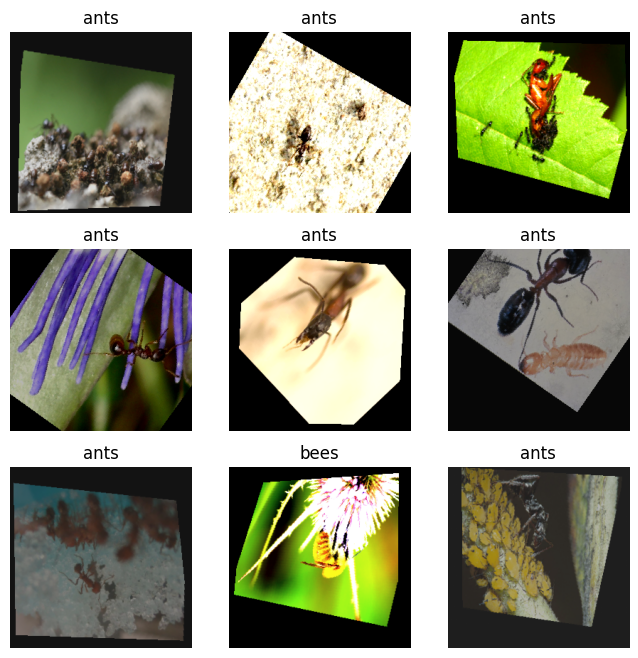

In [ ]:
plot_images(image_datasets['train'],mean, std)

# **Model overview: ResNet18**

We will utilize the well-known ResNet18 architecture, using it both to train models from scratch and to fine-tune pre-trained weights for transfer learning. For additional information about **ResNet18**, please refer to this [link](https://arxiv.org/abs/1512.03385).

**ResNet18 Architecture**

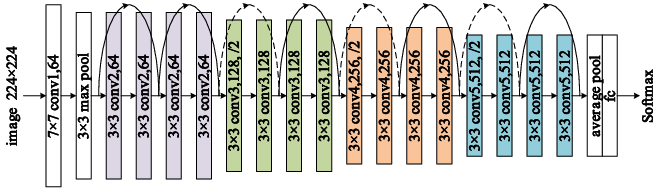

In [ ]:
model = models.resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Finetuning the ResNet18 Model**




We will be loading in a pretrained version of **ResNet18** and replacing its final fully connected layer to match our target classes. In this approach, we fine-tune the entire network—both the convolutional layers and the fully connected layers—using the pretrained weights as a starting point.

In [ ]:
def train_test_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Train and test a PyTorch model with learning rate scheduling and model checkpointing.

    This function performs training and validation over a specified number of epochs.
    During training, it schedules the learning rate using a provided scheduler and saves
    the best performing model (based on validation accuracy). After training, the best model
    is evaluated on the test set.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        criterion (callable): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer for model parameters.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        num_epochs (int): Number of epochs for training (default is 25).

    Returns:
        model (torch.nn.Module): The trained model with the best validation weights loaded.
        val_acc_h (list): History of validation accuracy for each epoch.
        train_acc_h (list): History of training accuracy for each epoch.
        test_acc (torch.Tensor): Accuracy on the test dataset.
    """
    import time, copy

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_h = []
    train_acc_h = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1} LR {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass and track history only in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only in train mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the learning rate scheduler after the training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_acc_h.append(epoch_acc)
            elif phase == 'val':
                val_acc_h.append(epoch_acc)
                # Save the model if validation accuracy improved
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    # Testing phase
    print('Testing started')
    phase = 'test'
    # Load best model weights
    model.load_state_dict(best_model_wts)
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes[phase]
    test_acc = running_corrects.double() / dataset_sizes[phase]

    time_elapsed = time.time() - since
    print('Training and testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print(f'Best val Acc: {best_acc:.4f}')
    print(f'Test Acc: {test_acc:.4f}')

    return model, val_acc_h, train_acc_h, test_acc

In [ ]:
model_conv = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
for param in model_conv.parameters():
    param.requires_grad = True

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_conv_ft, val_acc_h, train_acc_h, test_acc = train_test_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9 LR 0.001000
----------
train Loss: 0.7246 Acc: 0.5309
val Loss: 0.6976 Acc: 0.5543
Epoch 1/9 LR 0.001000
----------
train Loss: 0.7227 Acc: 0.5062
val Loss: 0.6799 Acc: 0.5761
Epoch 2/9 LR 0.001000
----------
train Loss: 0.6482 Acc: 0.6049
val Loss: 0.5723 Acc: 0.6957
Epoch 3/9 LR 0.001000
----------
train Loss: 0.5913 Acc: 0.7160
val Loss: 0.5086 Acc: 0.7391
Epoch 4/9 LR 0.001000
----------
train Loss: 0.5552 Acc: 0.7284
val Loss: 0.4567 Acc: 0.7935
Epoch 5/9 LR 0.001000
----------
train Loss: 0.4780 Acc: 0.8189
val Loss: 0.4352 Acc: 0.8261
Epoch 6/9 LR 0.001000
----------
train Loss: 0.4757 Acc: 0.7984
val Loss: 0.3823 Acc: 0.8370
Epoch 7/9 LR 0.000100
----------
train Loss: 0.4304 Acc: 0.8436
val Loss: 0.3798 Acc: 0.8478
Epoch 8/9 LR 0.000100
----------
train Loss: 0.4491 Acc: 0.8354
val Loss: 0.3772 Acc: 0.8478
Epoch 9/9 LR 0.000100
----------
train Loss: 0.4080 Acc: 0.8848
val Loss: 0.3770 Acc: 0.8587
Testing started
Training and testing complete in 0m 42s
Best val Acc: 

#### **Dynamic Quantization for More Layers**

Dynamic quantization in PyTorch is designed to be simple and effective. However, it primarily supports certain layer types like `nn.Linear`. For dynamic quantization, the weights are quantized during runtime, which makes it easy to apply but restricts the scope of quantization to layers that involve matrix multiplications (such as fully connected layers). It does not typically support convolutional layers (`nn.Conv2d`), which are central to models like ResNet.

Despite this limitation, we can still use dynamic quantization for the `Linear` layers in the ResNet architecture. To apply quantization to a wider range of layers, such as convolutional layers, **static quantization** or **quantization aware training (QAT)** is required.

In [ ]:
# Assuming model_conv_ft is your retrained model (e.g., ResNet18)
# Apply dynamic quantization only to nn.Linear layers
model_conv_ft = model_conv_ft.to('cpu').float()
D_quantized_model = torch.quantization.quantize_dynamic(
    model_conv_ft,  # Retrained model
    {nn.Linear},    # Quantize only Linear layers
    dtype=torch.qint8  # Use 8-bit integer quantization
)

# Move the quantized model to CPU (necessary for dynamic quantization)
D_quantized_model = D_quantized_model.to('cpu')
inputs = torch.randn(1, 3, 256, 256).float().to('cpu')

with torch.no_grad():
    outputs = D_quantized_model(inputs)
    print(outputs)

tensor([[ 0.2211, -1.0220]])


In [ ]:
# Currently dynamic quantized linear layer (quantized::linear_dynamic) does not support execution on the CUDA (GPU) backend.
D_quantized_model = D_quantized_model.to('cpu')
D_quantized_model.eval()

running_loss = 0.0
running_corrects = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to('cpu')
        labels = labels.to('cpu')
        outputs = D_quantized_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        test_loss = running_loss / dataset_sizes['test']
        test_acc_q = running_corrects.double() / dataset_sizes['test']

print(f'Test acc before quantization: {test_acc}')
print(f'Test acc after quantization: {test_acc_q}')

Test acc before quantization: 0.9180327868852459
Test acc after quantization: 0.9180327868852459


In [ ]:
def benchmark_model(model, device, dataloader, num_trials=10):
    model.to(device)
    model.eval()

    start_time = time.time()
    with torch.no_grad():
        for trial in range(num_trials):
            inputs, _ = next(iter(dataloader))
            inputs = inputs.to(device)
            model(inputs)
            if trial % 2 == 0:
                print(f"{trial + 1} trials completed")

    end_time = time.time()
    average_time = (end_time - start_time) / num_trials
    return average_time

In [ ]:
# Benchmark the original model
original_model_time = benchmark_model(model_conv_ft, "cpu", dataloaders['test'])
print(f"Average inference time of original model: {original_model_time:.6f} seconds.\n")

# Benchmark the quantized model
quantized_model_time = benchmark_model(D_quantized_model, "cpu", dataloaders['test'])
print(f"Average inference time of quantized model: {quantized_model_time:.6f} seconds.\n")

1 trials completed
3 trials completed
5 trials completed
7 trials completed
9 trials completed
Average inference time of original model: 5.262737 seconds.

1 trials completed
3 trials completed
5 trials completed
7 trials completed
9 trials completed
Average inference time of quantized model: 5.201681 seconds.



In [ ]:
# Function to calculate model size in megabytes (MB)
def model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

# Calculate the size of the original and quantized models
original_model_size = model_size(model_conv_ft)
quantized_model_size = model_size(D_quantized_model)

print(f"Original model size: {original_model_size:.2f} MB\n")
print(f"Quantized model size: {quantized_model_size:.2f} MB")

Original model size: 42.68 MB

Quantized model size: 42.67 MB


# **Quantization Aware Training (QAT)**

Quantization Aware Training (QAT) is a powerful approach that enables the model to simulate quantized behavior during training. This process helps the model adjust to the errors introduced by quantization and thus maintain high accuracy after quantization. QAT is particularly effective for models with convolutional layers, such as ResNet, where maintaining accuracy is critical for tasks like image classification.

In QAT, both the weights and activations are quantized during training, but the gradients are computed using floating-point precision. The forward pass simulates the effect of quantization through **fake quantization** layers (also known as fake quantized operations). After the model is trained, these fake quantized layers are replaced by real quantization layers during the conversion step.

### **Steps to Perform QAT**:

1. **Model Preparation**: Before starting QAT, the model must be modified by adding `QuantStub` and `DeQuantStub` layers. These stubs simulate the quantization and dequantization of the inputs and outputs of the model. Additionally, we replace `nn.Linear` and `nn.Conv2d` layers with quantization-aware versions of these layers using the PyTorch `prepare_qat` function. This function introduces the necessary fake quantization operations for simulating quantization during training.
   
2. **Training**: The model is trained with quantization in mind, using the same training loop as in standard training. However, during the forward pass, the activations are quantized to simulate lower precision.
   
3. **Model Conversion**: Once training is complete, the fake quantization layers are replaced with actual quantized operations using the `convert` function.

### **Example of Preparing a Model for QAT:**

We modify a pre-trained ResNet-18 by adding the `QuantStub` and `DeQuantStub` layers, and then prepare the model for QAT.

In [ ]:
class ResNet18_QAT(nn.Module):
    def __init__(self, model):
        super(ResNet18_QAT, self).__init__()
        self.quant = QuantStub()
        self.model = model
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

In this example, `QuantStub` is used to quantize inputs, and `DeQuantStub` is used to dequantize the outputs after the final layer. The `prepare_qat` function introduces fake quantization operations that allow the model to simulate quantization during training.

#### **Training the Model with QAT:**

After the model is prepared, the training loop remains the same as a standard training loop. Once training is completed, we convert the model into a fully quantized version:

In [ ]:
def train_test_model_q(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Train and test a quantization-aware training (QAT) model.

    This function trains the model using both training and validation datasets over a specified
    number of epochs. It computes and prints loss and accuracy for each phase (training and validation)
    and then evaluates the model on a separate test dataset. Note that the scheduler is stepped during
    the training phase on every batch.

    Args:
        model (torch.nn.Module): The model to be trained.
        criterion (callable): Loss function (e.g., CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        num_epochs (int, optional): Number of epochs to train the model. Default is 25.

    Returns:
        model (torch.nn.Module): The trained model.
        val_acc_h (list): History of validation accuracy for each epoch.
        train_acc_h (list): History of training accuracy for each epoch.
        test_acc (torch.Tensor): Test accuracy computed on the test dataset.
    """
    import time
    since = time.time()

    val_acc_h = []
    train_acc_h = []

    for epoch in range(num_epochs):
        current_lr = scheduler.get_last_lr()[0]
        print(f'Epoch {epoch}/{num_epochs - 1} | LR: {current_lr:.6f}')
        print('-' * 40)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data for the current phase.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # Update statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_acc_h.append(epoch_acc)
            elif phase == 'val':
                val_acc_h.append(epoch_acc)

    # Test phase (no gradient computation)
    print('Testing started...')
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']

    time_elapsed = time.time() - since
    print('Training and testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

    return model, val_acc_h, train_acc_h, test_acc

We continue setting up training by configuring a `QConfig` with custom fake quantization parameters and then applying the `prepare_qat` function to automatically insert fake quantization layers throughout the model. In doing so, it transforms a pretrained model (in this case, **ResNet18**) into a quantization-ready version.

In [ ]:
model_conv_ft = model_conv_ft.to('cpu')
model_qat = ResNet18_QAT(model_conv_ft)

# Custom QAT config with quant_min and quant_max for 8-bit quantization
custom_fake_quant = FakeQuantize.with_args(quant_min=0, quant_max=255)

# Use the default QAT config and override the activation observer
qat_config = get_default_qat_qconfig('fbgemm')
qat_config = torch.quantization.QConfig(
    activation=custom_fake_quant,
    weight=qat_config.weight
)

model_qat.qconfig = qat_config
model_qat = prepare_qat(model_qat)
model_qat = model_qat.to(device)

criterion_qat = nn.CrossEntropyLoss()

optimizer_qat = optim.SGD(model_qat.parameters(), lr=0.0001, momentum=0.25)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler_qat = lr_scheduler.StepLR(optimizer_qat, step_size=7, gamma=0.1)

In [ ]:
model_qat, val_acc_h, train_acc_h, test_acc = train_test_model_q(model_qat, criterion_qat, optimizer_qat, exp_lr_scheduler_qat, num_epochs=10)

Epoch 0/9 | LR: 0.000100
----------------------------------------
Train Loss: 0.4450 Acc: 0.8519
Val Loss: 0.3727 Acc: 0.8370
Epoch 1/9 | LR: 0.000100
----------------------------------------
Train Loss: 0.4073 Acc: 0.8889
Val Loss: 0.3676 Acc: 0.8370
Epoch 2/9 | LR: 0.000010
----------------------------------------
Train Loss: 0.4499 Acc: 0.8272
Val Loss: 0.3619 Acc: 0.8478
Epoch 3/9 | LR: 0.000010
----------------------------------------
Train Loss: 0.4333 Acc: 0.8272
Val Loss: 0.3642 Acc: 0.8478
Epoch 4/9 | LR: 0.000001
----------------------------------------
Train Loss: 0.4195 Acc: 0.8519
Val Loss: 0.3615 Acc: 0.8478
Epoch 5/9 | LR: 0.000001
----------------------------------------
Train Loss: 0.4466 Acc: 0.8436
Val Loss: 0.3707 Acc: 0.8587
Epoch 6/9 | LR: 0.000000
----------------------------------------
Train Loss: 0.4598 Acc: 0.8354
Val Loss: 0.3707 Acc: 0.8478
Epoch 7/9 | LR: 0.000000
----------------------------------------
Train Loss: 0.4366 Acc: 0.8642
Val Loss: 0.3671 Acc:

In [ ]:
def plot_acc(train_acc_h,val_acc_h):
    plt.figure(figsize=(10,6))
    plt.xlabel('Iteration')
    plt.ylabel('Acc')
    plt.title('Acc by Iteration')
    plt.plot(torch.tensor(train_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(val_acc_h, device = 'cpu')*100)
    plt.legend(['train', 'valid'])

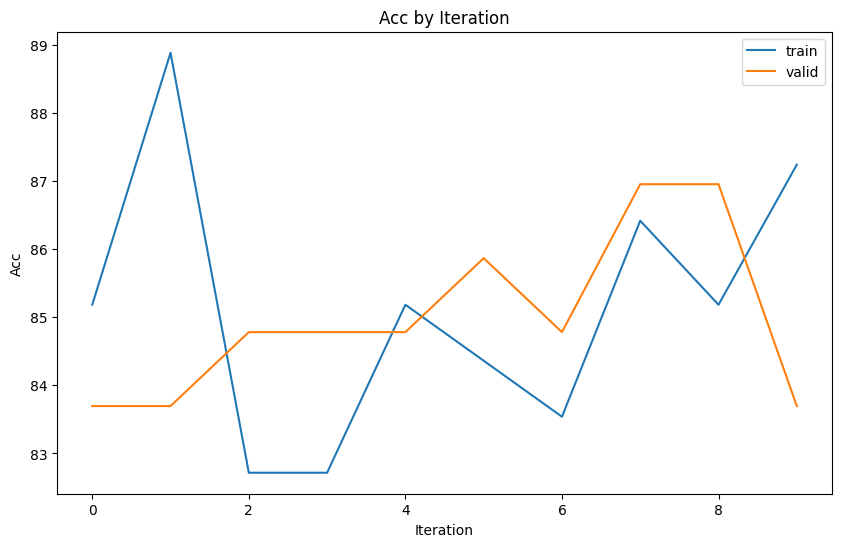

In [ ]:
plot_acc(train_acc_h, val_acc_h)

In [ ]:
model_qat.eval()
model_quantized_final = convert(model_qat.to('cpu').eval(), inplace=False)

In [ ]:
# Function to calculate model size in megabytes (MB)
def model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

original_model_size = model_size(model_conv_ft)
quantized_model_size = model_size(model_quantized_final)

print(f"\nOriginal model size: {original_model_size:.2f} MB")
print(f"Quantized model size: {quantized_model_size:.2f} MB")


Original model size: 42.68 MB
Quantized model size: 0.07 MB


In [ ]:
model_quantized_final

ResNet18_QAT(
  (quant): Quantize(scale=tensor([0.0187]), zero_point=tensor([114]), dtype=torch.quint8)
  (model): ResNet(
    (conv1): QuantizedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.2902217507362366, zero_point=127, padding=(3, 3), bias=False)
    (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.10575834661722183, zero_point=181, padding=(1, 1), bias=False)
        (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.030741408467292786, zero_point=161, padding=(1, 1), bias=False)
        (bn2): QuantizedBatchNor

### **Conclusion on Quantization Methods**

- **Dynamic Quantization**: This method is ideal for simpler models where only fully connected layers need to be quantized, providing immediate performance gains with minimal setup.

- **Static Quantization**: Useful when both weights and activations need to be quantized for models involving convolutional layers. This method requires post-training calibration.

- **Quantization Aware Training (QAT)**: The most comprehensive solution, allowing for quantization of more complex models like ResNet.

### **HOMEWORK (Optional)**

- **Exercise 1: Quantization Trade-offs**  
  Apply dynamic quantization to the fine-tuned model and measure the inference time and accuracy on the test set before and after quantization. Investigate how quantization affects model size and speed.

- **Exercise 2: Post-Training Static Quantization**  
  If you want to quantize convolution layers as well without `QAT`, you can try **static quantization**. Static quantization also uses calibration data to find scale/zero-point for each layer, letting you quantize more layers (including convolutions) to 8-bit.
